In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
from matplotlib import rc

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz

import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# frequency information: histogram, cumulant histogram

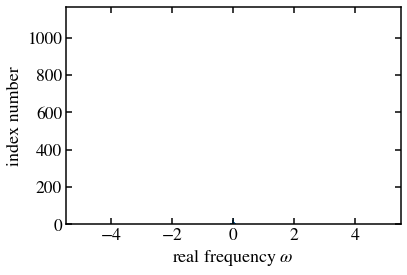

In [2]:
D = 1
out_node = 2
npoint = 2001
N = 10000
directory = '../1_dmftsolver/NRG'
weq = np.linspace(-5, 5, npoint)


w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/Bethe_41_beta10000/Bethe-{2.25:.3f}.dat', \
                       unpack = True, dtype = 'complex128')

#plt.plot(w.real, np.arange(len(w)))
#plt.xlabel(r'real frequency $\omega$')
#plt.ylabel('cumulant number')
#plt.axhspan(1319-500, 1319+500, alpha=0.5, color='#ffee52')
#plt.annotate(r'$\omega\simeq0$', xy=(0.4, 0.475), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.show()


number, bins, patches = plt.hist(w.real, bins=npoint)
plt.xlabel(r'real frequency $\omega$')
plt.ylabel('index number')
plt.show()

def G(x):
    return np.array([simps(x/(1j*omega[i]-w.real), w) for i in range (N)])
def Geq(x):
    return np.array([simps(x/(1j*omega[i]-weq), weq) for i in range (N)])

def Gmat(x):
    return -np.array([G(xx) for i, xx in enumerate(x)])/np.pi
def Geqmat(x):
    return -np.array([Geq(xx) for i, xx in enumerate(x)])/np.pi

omega = np.pi/10000 * (2*np.arange(N)+1) # w_n
iwnumber = -Geq(number).imag/np.pi

#plt.plot(omega, iwnumber)
#plt.xlabel(r'imag frequency $i\omega_n$')
#plt.ylabel('index number')
#plt.yscale('log')

# Data: NRG, ED

In [3]:
beta = 100
N = 10000
omega = np.pi/beta * (2*np.arange(N)+1)
def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (N)])


directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93

U = np.array([0.01*i for i in range(50, 501)])
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed_up = np.zeros((len(U1_ed), 10000), dtype = 'float64')
x_test_ed_dn = np.zeros((len(U2_ed), 10000), dtype = 'float64')
for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed_up[i][:N] = EDbath(e,V).imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed_dn[i][:N] = EDbath(e,V).imag
x_test_ed_up = torch.FloatTensor(-x_test_ed_up)
x_test_ed_dn = torch.FloatTensor(-x_test_ed_dn)

y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)
UU_ed = np.concatenate((U1_ed, U2_ed))

# To bring frozen Neural Network Model

In [4]:
class iLRNet(nn.Module):
    def __init__(self, activate = None):
        super(iLRNet, self).__init__()
        self.W1 = nn.Linear(10000, out_node)#, bias=False)
        self.b1 = nn.Linear(out_node, 1)#, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        
        W1_ = np.loadtxt('frozen_mat/iw_LR_W1.txt', dtype='float64')
        b1_ = np.loadtxt('frozen_mat/iw_LR_b1.txt', dtype='float64')
        self.W1.weight.data = torch.FloatTensor(W1_)
        self.b1.weight.data = torch.FloatTensor(b1_)

    def forward(self, x):
        x = self.W1(x)+self.b1.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)
    
    
class iNN10Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(iNN10Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(10000, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        
        self.W1.weight.data = torch.load('frozen_mat/iw_NN10_W1.pt')
        self.W2.weight.data = torch.load('frozen_mat/iw_NN10_W2.pt')
        self.b1.weight.data = torch.load('frozen_mat/iw_NN10_b1.pt')
        self.b2.weight.data = torch.load('frozen_mat/iw_NN10_b2.pt')
        
    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

class iNN100Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(iNN100Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(10000, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        self.W1.weight.data = torch.load('frozen_mat/iw_NN100_W1.pt')
        self.W2.weight.data = torch.load('frozen_mat/iw_NN100_W2.pt')
        self.b1.weight.data = torch.load('frozen_mat/iw_NN100_b1.pt')
        self.b2.weight.data = torch.load('frozen_mat/iw_NN100_b2.pt')
        
    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [5]:
func = nn.Sigmoid
iLRmodel = iLRNet(activate = func)
iNN10model = iNN10Net(node = 10, activate = func)
iNN100model = iNN100Net(node = 100, activate = func)

In [6]:
iNN100model.load_state_dict(torch.load('iNN100model.pth'))
iNN10model.load_state_dict(torch.load('iNN10model.pth'))

FileNotFoundError: [Errno 2] No such file or directory: 'iNN100model.pth'

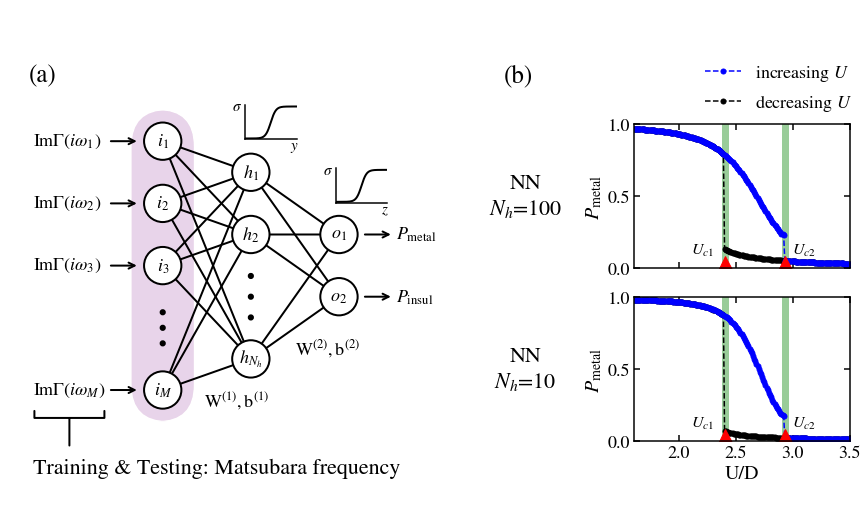

In [37]:
figuresave = True
xsize, ysize=1.2, 1.8
ax2 = plt.axes((0, 0, xsize, ysize), xticks = [], \
    yticks = [], facecolor = 'None', frameon = False)

bb = -0.06
plt.gcf().text(0.05,ysize-0.2+bb, '(a)', fontsize = 25)
plt.gcf().text(xsize-0.05,ysize-0.2+bb, '(b)', fontsize = 25)

inode_x, inode_y = 0.30, 0.8+bb
hnode_x, hnode_y = 0.47, inode_y-0.12/2
onode_x, onode_y = 0.64, inode_y-0.12*2+0.12/2

#(a)-1 ###########################################################

r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.09, edgecolor = 'none', facecolor = 'r')
r2 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.09, edgecolor = 'none', facecolor = 'b')
ax2.add_patch(r1)
ax2.add_patch(r2)

for i in range(3):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
    ax2.text(inode_x, inode_y-0.12*i, fr'$i_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
    ax2.text(inode_x-0.25, inode_y-0.12*i, fr'Im$\Gamma(i\omega_{i+1})$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
    ax2.annotate('', xy=(inode_x-0.1, 0.8-0.12*i+bb), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(3):
    o = mpatches.Circle((inode_x, inode_y-0.12*3+0.03-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
ax2.add_patch(o)
ax2.text(inode_x, inode_y-0.12*4, r'$i_{M}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
ax2.text(inode_x-0.25, inode_y-0.12*4, r'Im$\Gamma(i\omega_{M})$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})

for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,ls='-', zorder = 2)
    ax2.add_patch(o)
    ax2.text(hnode_x, hnode_y-0.12*i, fr'$h_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,ls='-', zorder = 2)
ax2.add_patch(o)
ax2.text(hnode_x, hnode_y-0.12*3, r'$h_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)

for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
    ax2.text(onode_x, onode_y-0.12*i, fr'$o_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
    ax2.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax2.text(onode_x+0.11, onode_y, r'$P_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax2.transAxes)
ax2.text(onode_x+0.11, onode_y-0.12, r'$P_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax2.transAxes)

iy_coord = [inode_y-0.12*i for i in range(3)]
iy_coord.append(inode_y-0.12*4) # i = 0~3
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax2.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0, lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax2.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0, lw=2), \
            size = 'large', zorder = 1)

ax2.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}^{(1)}, \mathrm{b}^{(1)}$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}^{(2)}, \mathrm{b}^{(2)}$', fontsize = 18, \
             va='center', transform = ax2.transAxes)

ax2.text(inode_x-0.25, inode_y-0.12*4-0.15, 'Training & Testing: Matsubara frequency', fontsize = 22, \
             ha='left', va='center', transform = ax2.transAxes)
ax2.annotate('', xy=(inode_x-0.18, inode_y-0.12*4-0.05), xytext=(inode_x-0.18, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=2), transform = ax2.transAxes)

ax5 = plt.axes((0.55, 1.44+bb*1.7, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax6 = plt.axes((0.76, 1.22+bb*1.7, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax5.spines['top'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax5.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax5.set_xlabel(r'$y$', fontsize=15)
ax5.xaxis.set_label_coords(0.95, -0.03)
ax5.yaxis.set_label_coords(-0.15, 0.75)
ax5.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax5.set_ylim(-0.03,1.05)
ax5.set_xlim(-5,5)
ax6.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax6.set_xlabel(r'$z$', fontsize=15)
ax6.xaxis.set_label_coords(0.95, -0.03)
ax6.yaxis.set_label_coords(-0.15, 0.75)
ax6.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax6.set_ylim(-0.03,1.05)
ax6.set_xlim(-5,5)

# (b) #################################################################
a = 0.15
ax30 = plt.axes((1.45, 0.8+a+bb, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax31 = plt.axes((1.45, 0.2+a+bb, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)

ax30.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax30.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax30.plot(U2_ed, iNN100model.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax30.plot(U1_ed, iNN100model.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax30.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax30.set_ylim(0,1)
ax30.set_xlim(1.6,3.5)

ax31.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax31.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax31.plot(U2_ed, iNN10model.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax31.plot(U1_ed, iNN10model.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax31.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax31.set_ylim(0,1)
ax31.set_xlim(1.6,3.5)


ax30.set_xticks([2.0, 2.5, 3.0, 3.5])
ax31.set_xticks([2.0, 2.5, 3.0, 3.5])
ax30.set_xticklabels([])
ax30.set_yticks([0.0, 0.5, 1.0])
ax31.set_yticks([0.0, 0.5, 1.0])
ax30.tick_params(labelsize=18)
ax31.tick_params(labelsize=18)

ax30.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax31.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax31.set_xlabel(r'U/D', fontsize=20)


ax30.text(-0.5, 0.5, 'NN\n'+r'$N_h$=100', fontsize = 22, \
          ha='center',va='center', transform = ax30.transAxes)
ax31.text(-0.5, 0.5, 'NN\n'+r'$N_h$=10', fontsize = 22, \
          ha='center',va='center', transform = ax31.transAxes)
handles,labels = ax30.get_legend_handles_labels()
ax30.legend([handles[1], handles[0]], [labels[1], labels[0]],ncol=1, bbox_to_anchor=(0.67, 1.25), loc='center', fontsize=18)

if figuresave == True: plt.savefig('fig2_1.pdf', bbox_inches='tight')


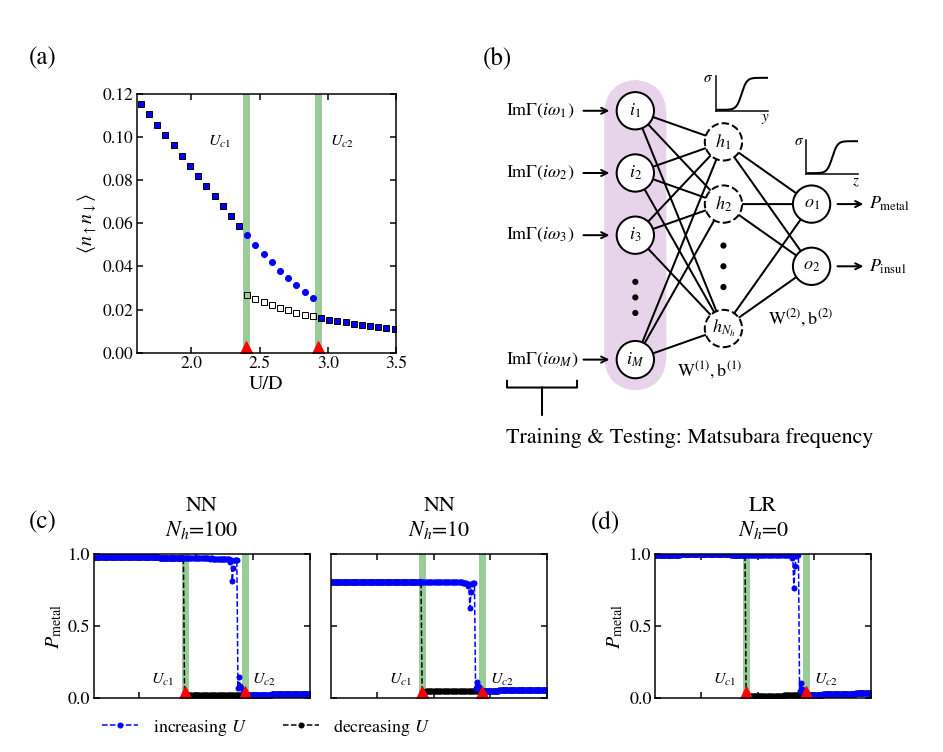

In [109]:
xsize, ysize=1.2, 1.8
ax1 = plt.axes((0.1, 0, xsize, ysize), xticks = [], \
    yticks = [], facecolor = 'None', frameon = False)
plt.gcf().text(0.15,ysize-0.2, '(a)', fontsize = 25)
plt.gcf().text(xsize,ysize-0.2, '(b)', fontsize = 25)

inode_x, inode_y = 0.35, 0.8
hnode_x, hnode_y = 0.52, inode_y-0.12/2
onode_x, onode_y = 0.69, inode_y-0.12*2+0.12/2

# (a)-1 ######################################################################
ax11 = plt.axes((0.4, 0.6, 0.6, 0.9), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)

ax11.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax11.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax11.plot(U1_ed[::6], docc1[::6], 'bo')
ax11.plot(U2_ed[::6], docc2[::6], 'ks', mfc='none')
ax11.set_xlim(1.6, 3.5)
ax11.set_ylim(0, 0.12)
ax11.set_xticks([2.0, 2.5, 3.0, 3.5])
ax11.set_yticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])
ax11.set_ylabel(r'$\langle n_\uparrow n_\downarrow \rangle$', fontsize=20)
ax11.set_xlabel('U/D', fontsize=20)
ax11.annotate(r'$U_{c1}$', xy=(0.32, 0.8), xycoords = 'axes fraction', fontsize=16, ha='center')
ax11.annotate(r'$U_{c2}$', xy=(0.79, 0.8), xycoords = 'axes fraction', fontsize=16, ha='center')
ax11.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)

#(a)-2 ###########################################################
ax2 = plt.axes((xsize-0.15, 0, xsize, ysize), xticks = [], \
    yticks = [], facecolor = 'None', frameon = False)
inode_x, inode_y = 0.42, 0.8
hnode_x, hnode_y = 0.59, inode_y-0.12/2
onode_x, onode_y = 0.76, inode_y-0.12*2+0.12/2

r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.09, edgecolor = 'none', facecolor = 'r')
r2 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.09, edgecolor = 'none', facecolor = 'b')
ax2.add_patch(r1)
ax2.add_patch(r2)

for i in range(3):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
    ax2.text(inode_x, inode_y-0.12*i, fr'$i_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
    ax2.text(inode_x-0.25, inode_y-0.12*i, fr'Im$\Gamma(i\omega_{i+1})$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
    ax2.annotate('', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(3):
    o = mpatches.Circle((inode_x, inode_y-0.12*3+0.03-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
ax2.add_patch(o)
ax2.text(inode_x, inode_y-0.12*4, r'$i_{M}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
ax2.text(inode_x-0.25, inode_y-0.12*4, r'Im$\Gamma(i\omega_{M})$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})

for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,ls='--', zorder = 2)
    ax2.add_patch(o)
    ax2.text(hnode_x, hnode_y-0.12*i, fr'$h_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,ls='--', zorder = 2)
ax2.add_patch(o)
ax2.text(hnode_x, hnode_y-0.12*3, r'$h_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)

for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2,zorder = 2)
    ax2.add_patch(o)
    ax2.text(onode_x, onode_y-0.12*i, fr'$o_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax2.transAxes)
    ax2.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax2.text(onode_x+0.11, onode_y, r'$P_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax2.transAxes)
ax2.text(onode_x+0.11, onode_y-0.12, r'$P_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax2.transAxes)

iy_coord = [inode_y-0.12*i for i in range(3)]
iy_coord.append(inode_y-0.12*4) # i = 0~3
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax2.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0, lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax2.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0, lw=2), \
            size = 'large', zorder = 1)

ax2.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}^{(1)}, \mathrm{b}^{(1)}$', fontsize = 18, \
             va='center', transform = ax2.transAxes)
ax2.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}^{(2)}, \mathrm{b}^{(2)}$', fontsize = 18, \
             va='center', transform = ax2.transAxes)

ax7 = plt.axes((1.74, 1.44, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax8 = plt.axes((1.95, 1.22, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax7.spines['top'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax7.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax7.set_xlabel(r'$y$', fontsize=15)
ax7.xaxis.set_label_coords(0.95, -0.03)
ax7.yaxis.set_label_coords(-0.15, 0.75)
ax7.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax7.set_ylim(-0.03,1.05)
ax7.set_xlim(-5,5)
ax8.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax8.set_xlabel(r'$z$', fontsize=15)
ax8.xaxis.set_label_coords(0.95, -0.03)
ax8.yaxis.set_label_coords(-0.15, 0.75)
ax8.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax8.set_ylim(-0.03,1.05)
ax8.set_xlim(-5,5)
ax2.text(inode_x-0.25, inode_y-0.12*4-0.15, 'Training & Testing: Matsubara frequency', fontsize = 22, \
             ha='left', va='center', transform = ax2.transAxes)
ax2.annotate('', xy=(inode_x-0.18, inode_y-0.12*4-0.05), xytext=(inode_x-0.18, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=2), transform = ax2.transAxes)

# (b) #################################################################
a, b = -0.2, 0
plt.gcf().text(0.15,-0.01, '(c)', fontsize = 25)
plt.gcf().text(1.45,-0.01, '(d)', fontsize = 25)
ax30 = plt.axes((0.5+a, -0.6, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax31 = plt.axes((1.05+a, -0.6, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax32 = plt.axes((1.6+b, -0.6, 0.5, 0.5), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)


ax30.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax30.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax30.plot(U2_ed, iNN100model.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax30.plot(U1_ed, iNN100model.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax30.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax30.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax30.set_ylim(0,1)
ax30.set_xlim(1.6,3.5)

ax31.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax31.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax31.plot(U2_ed, iNN10model.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax31.plot(U1_ed, iNN10model.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax31.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax31.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax31.set_ylim(0,1)
ax31.set_xlim(1.6,3.5)

ax32.axvline(U_c1_ed, c = '#99CC99', lw = '7'), ax32.axvline(U_c2_ed, c = '#99CC99', lw = '7')
ax32.plot(U2_ed, iLRmodel.forward(x_test_ed_dn).data[:,0], 'ko--', ms=5, label = r'decreasing $U$')
ax32.plot(U1_ed, iLRmodel.forward(x_test_ed_up).data[:,0], 'bo--', ms=5, label = r'increasing $U$')
ax32.annotate(r'$U_{c1}$', xy=(0.32, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax32.annotate(r'$U_{c2}$', xy=(0.79, 0.1), xycoords = 'axes fraction', fontsize=16, ha='center')
ax32.plot(np.array([U_c1_ed, U_c2_ed]), np.zeros(2), 'r^', ms=25)
ax32.set_ylim(0,1)
ax32.set_xlim(1.6,3.5)


ax30.set_xticks([2.0, 2.5, 3.0, 3.5])
ax31.set_xticks([2.0, 2.5, 3.0, 3.5])
ax32.set_xticks([2.0, 2.5, 3.0, 3.5])
ax30.set_xticklabels([])
ax31.set_xticklabels([])
ax32.set_xticklabels([])
ax30.set_yticks([0.0, 0.5, 1.0])
ax31.set_yticks([0.0, 0.5, 1.0])
ax32.set_yticks([0.0, 0.5, 1.0])
ax31.set_yticklabels([])

ax30.tick_params(labelsize=18)
ax31.tick_params(labelsize=18)
ax32.tick_params(labelsize=18)

ax30.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax40.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)
ax32.set_ylabel(r'$P_{\mathrm{metal}}$', fontsize=20)

#ax30.text(-0.45, 0.5, 'NRG', fontsize = 25, \
#          ha='center',va='center', transform = ax30.transAxes)
ax30.text(0.5, 1.25, 'NN\n'+r'$N_h$=100', fontsize = 22, \
          ha='center',va='center', transform = ax30.transAxes)
ax31.text(0.5, 1.25, 'NN\n'+r'$N_h$=10', fontsize = 22, \
          ha='center',va='center', transform = ax31.transAxes)
ax32.text(0.5, 1.25, 'LR\n'+r'$N_h$=0', fontsize = 22, \
          ha='center',va='center', transform = ax32.transAxes)
handles,labels = ax30.get_legend_handles_labels()
ax30.legend([handles[1], handles[0]], [labels[1], labels[0]],ncol=2, bbox_to_anchor=(0.8, -0.2), loc='center', fontsize=18)


plt.savefig('fig2_1.pdf', bbox_inches='tight')


In [13]:
r1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.09, edgecolor = 'none', facecolor = 'r')
r2 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56, \
    boxstyle = mpatches.BoxStyle("Round", pad = 0.02, \
        rounding_size = 0.07), \
    alpha = 0.09, edgecolor = 'none', facecolor = 'b')
ax1.add_patch(r1)
ax1.add_patch(r2)

# input layer
for i in range(1):
    o = mpatches.Circle((inode_x, inode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    ax1.text(inode_x, inode_y-0.12*i, fr'$i_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
    ax1.annotate('', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.08-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    o = mpatches.Circle((inode_x, inode_y-0.37-0.03*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    
for i in range(2):
    o = mpatches.Circle((inode_x, inode_y-0.19-0.10*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    ax1.annotate('', xy=(inode_x-0.1, inode_y-0.19-0.10*i), xytext=(inode_x-0.05, inode_y-0.19-0.10*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax1.text(inode_x, inode_y-0.19-0.10*0, r'$i_N$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
ax1.text(inode_x, inode_y-0.19-0.10*1, r'$i_{N+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)

ax1.text(inode_x-0.18, inode_y, '$\epsilon_{-n_{w}}$', fontsize = 20, \
             va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.18, inode_y-0.19, r'$\epsilon_{n_{w}}$', fontsize = 20, \
             va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.18, inode_y-0.19-0.10*1, r'$V_{-n_{w}}$', fontsize = 20, \
             va='center', transform = ax1.transAxes)
ax1.text(inode_x-0.18, inode_y-0.12*4, r'$V_{n_{w}}$', fontsize = 20, \
             va='center', transform = ax1.transAxes)

o = mpatches.Circle((inode_x, inode_y-0.12*4), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
ax1.add_patch(o)
ax1.text(inode_x, inode_y-0.12*4, r'$i_{2N}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)

ax1.annotate('', xy=(inode_x-0.1, inode_y-0.12*4), xytext=(inode_x-0.05, inode_y-0.12*4), \
             xycoords = 'axes fraction', ha='center', va='center', \
             arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})

# hidden layer
for i in range(2):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
    ax1.add_patch(o)
    ax1.text(hnode_x, hnode_y-0.12*i, fr'$h_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
for i in range(3):
    o = mpatches.Circle((hnode_x, hnode_y-0.12*2+0.04-0.04*i), \
        radius = 0.004, facecolor = 'k', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
o = mpatches.Circle((hnode_x, hnode_y-0.12*3), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, ls='--', zorder = 2)
ax1.add_patch(o)
ax1.text(hnode_x, hnode_y-0.12*3, r'$h_{N_h}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
# output layer
for i in range(2):
    o = mpatches.Circle((onode_x, onode_y-0.12*i), \
        radius = 0.036, facecolor = 'w', edgecolor = 'k', lw=2, zorder = 2)
    ax1.add_patch(o)
    ax1.text(onode_x, onode_y-0.12*i, fr'$o_{i+1}$', fontsize = 18, \
             ha='center', va='center', transform = ax1.transAxes)
    ax1.annotate('', xy=(onode_x+0.05, onode_y-0.12*i), xytext=(onode_x+0.1, onode_y-0.12*i), \
                 xycoords = 'axes fraction', ha='center', va='center', \
                 arrowprops={'arrowstyle':'<-', 'shrinkA':0, 'shrinkB':0,'lw':2,'mutation_scale':15})
ax1.text(onode_x+0.11, onode_y, r'$P_{\mathrm{metal}}$', fontsize = 18, \
        va='center', transform = ax1.transAxes)
ax1.text(onode_x+0.11, onode_y-0.12, r'$P_{\mathrm{insul}}$', fontsize = 18, \
        va='center', transform = ax1.transAxes)
# lines
iy_coord = [inode_y]
iy_coord.append(inode_y-0.19)
iy_coord.append(inode_y-0.19-0.10*1)
iy_coord.append(inode_y-0.12*4)
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord = [hnode_y-0.12*i for i in range(2)]
hy_coord.append(hnode_y-0.12*3) # j = 0~2
oy_coord = [onode_y-0.12*i for i in range(2)]
for i in range(4):
    for j in range(3):
        ax1.annotate('', \
            xy = (inode_x, iy_coord[i]), \
            xytext = (hnode_x, hy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
for i in range(3):
    for j in range(2):
        ax1.annotate('', \
            xy = (hnode_x, hy_coord[i]), \
            xytext = (onode_x, oy_coord[j]), \
            xycoords='axes fraction', textcoords='axes fraction', \
            arrowprops=dict(arrowstyle='-', color='black', \
                shrinkA=0,shrinkB=0,lw=2), \
            size = 'large', zorder = 1)
        
ax1.text(inode_x-0.18, inode_y-0.12*4-0.15, 'Training & Testing: bath parameters', fontsize = 22, \
             ha='left', va='center', transform = ax1.transAxes)
ax1.annotate('', xy=(inode_x-0.15, inode_y-0.12*4-0.05), xytext=(inode_x-0.15, inode_y-0.12*4-0.12),
            fontsize=14, ha='center', va='top', xycoords='axes fraction', 
            bbox=dict(boxstyle='round', fc='0.8'),
            arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=.5',lw=2), transform = ax1.transAxes)
ax1.text(inode_x+0.08, inode_y-0.12*4-0.02, r'$\mathrm{W}^{(1)}, \mathrm{b}^{(1)}$', fontsize = 18, \
             va='center', transform = ax1.transAxes)
ax1.text(hnode_x+0.085, hnode_y-0.12*3+0.02, r'$\mathrm{W}^{(2)}, \mathrm{b}^{(2)}$', fontsize = 18, \
             va='center', transform = ax1.transAxes)

ax5 = plt.axes((0.7, 1.44, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax6 = plt.axes((0.91, 1.22, 0.12, 0.12), xticks = [], \
    yticks = [], facecolor = 'None', frameon = True)
ax5.spines['top'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax5.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax5.set_xlabel(r'$y$', fontsize=15)
ax5.xaxis.set_label_coords(0.95, -0.03)
ax5.yaxis.set_label_coords(-0.15, 0.75)
ax5.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax5.set_ylim(-0.03,1.05)
ax5.set_xlim(-5,5)
ax6.plot(np.linspace(-5,5,200),1/(1+np.exp(-np.linspace(-5,5,200)*2)), c='k', lw=2)
ax6.set_xlabel(r'$z$', fontsize=15)
ax6.xaxis.set_label_coords(0.95, -0.03)
ax6.yaxis.set_label_coords(-0.15, 0.75)
ax6.set_ylabel(r'$\sigma$', fontsize=15, rotation=0)
ax6.set_ylim(-0.03,1.05)
ax6.set_xlim(-5,5)'''

'\nr1 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56,     boxstyle = mpatches.BoxStyle("Round", pad = 0.02,         rounding_size = 0.07),     alpha = 0.09, edgecolor = \'none\', facecolor = \'r\')\nr2 = mpatches.FancyBboxPatch((inode_x-0.04,inode_y-0.12*4-0.04), 0.08,0.56,     boxstyle = mpatches.BoxStyle("Round", pad = 0.02,         rounding_size = 0.07),     alpha = 0.09, edgecolor = \'none\', facecolor = \'b\')\nax1.add_patch(r1)\nax1.add_patch(r2)\n\n# input layer\nfor i in range(1):\n    o = mpatches.Circle((inode_x, inode_y-0.12*i),         radius = 0.036, facecolor = \'w\', edgecolor = \'k\', lw=2, zorder = 2)\n    ax1.add_patch(o)\n    ax1.text(inode_x, inode_y-0.12*i, fr\'$i_{i+1}$\', fontsize = 18,              ha=\'center\', va=\'center\', transform = ax1.transAxes)\n    ax1.annotate(\'\', xy=(inode_x-0.1, 0.8-0.12*i), xytext=(inode_x-0.05, inode_y-0.12*i),                  xycoords = \'axes fraction\', ha=\'center\', va=\'center\',                 